In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\cleaned_data\Fleet Dataset.csv")

In [3]:
df.shape

(1583, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Parent Airline        1583 non-null   object 
 1   Airline               1583 non-null   object 
 2   Aircraft Type         1583 non-null   object 
 3   Current               859 non-null    float64
 4   Future                188 non-null    float64
 5   Historic              1113 non-null   float64
 6   Total                 1484 non-null   float64
 7   Orders                348 non-null    float64
 8   Unit Cost             1548 non-null   object 
 9   Total Cost (Current)  1556 non-null   object 
 10  Average Age           820 non-null    float64
dtypes: float64(6), object(5)
memory usage: 136.2+ KB


Handle missing values, fix datatypes, rename columns, remove duplicates etc.

In [5]:
# Check null values
df.isna().sum()

Parent Airline             0
Airline                    0
Aircraft Type              0
Current                  724
Future                  1395
Historic                 470
Total                     99
Orders                  1235
Unit Cost                 35
Total Cost (Current)      27
Average Age              763
dtype: int64

In [6]:
df.describe()

,Current,Future,Historic,Total,Orders,Average Age
count,859.000000,188.000000,1113.000000,1484.000000,348.000000,820.000000
mean,24.033760,3.382979,14.513028,24.955526,26.419540,10.115000
std,41.091234,4.656331,23.763373,46.651526,43.024179,6.859362
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.100000
25%,5.000000,1.000000,3.000000,4.000000,5.000000,5.000000
50%,12.000000,2.000000,7.000000,11.000000,13.500000,8.900000
75%,26.500000,4.000000,16.000000,27.000000,28.250000,14.500000
max,718.000000,38.000000,325.000000,952.000000,400.000000,39.000000


In [7]:
df.head()
# issue: too many null values and '$' in total Cost column

,Parent Airline,Airline,Aircraft Type,Current,Future,Historic,Total,Orders,Unit Cost,Total Cost (Current),Average Age
0,Aegean Airlines,Aegean Airlines,Airbus A319,1.0,NaN,3.0,4.0,NaN,$90,$90,11.6
1,Aegean Airlines,Olympic Air,Airbus A319,NaN,NaN,8.0,8.0,NaN,$90,$0,NaN
2,Aegean Airlines,Aegean Airlines,Airbus A320,38.0,NaN,3.0,41.0,NaN,$98,"$3,724",7.5
3,Aegean Airlines,Olympic Air,Airbus A320,NaN,NaN,9.0,9.0,NaN,$98,$0,NaN
4,Aegean Airlines,Aegean Airlines,Airbus A321,8.0,NaN,NaN,8.0,NaN,$115,$919,10.3


In [8]:
# convert currency column

currency_columns = ['Unit Cost', 'Total Cost (Current)']

for col in currency_columns:
    df[col] = df[col].replace({r'\$': '', ',': ''}, regex=True).astype(float)

df[currency_columns].dtypes, df[currency_columns].head()

(Unit Cost               float64
 Total Cost (Current)    float64
 dtype: object,
    Unit Cost  Total Cost (Current)
 0       90.0                  90.0
 1       90.0                   0.0
 2       98.0                3724.0
 3       98.0                   0.0
 4      115.0                 919.0)

In [9]:
# 1. Fill Count columns with 0 (Safe assumption: No data = 0 planes)
count_cols = ['Current', 'Future', 'Historic', 'Orders', 'Total']
df[count_cols] = df[count_cols].fillna(0)

# 2. Fill Cost/Age columns with Median (Safe assumption: Unknown cost ~ Market avg)
avg_cols = ['Unit Cost', 'Total Cost (Current)', 'Average Age']
for col in avg_cols:
    df[col] = df[col].fillna(df[col].median())

In [10]:
df.nunique()

Parent Airline          117
Airline                 280
Aircraft Type           101
Current                 114
Future                   19
Historic                 94
Total                   142
Orders                   84
Unit Cost                55
Total Cost (Current)    488
Average Age             242
dtype: int64

In [11]:
# Most common 5 types (Aircrafts)
df['Aircraft Type'].value_counts().head(5)

Aircraft Type
Boeing 737     147
Airbus A320    135
Airbus A330     86
Boeing 767      83
Airbus A321     79
Name: count, dtype: int64

In [12]:
# Average cost for each aircraft type
avg_cost = df.groupby('Aircraft Type')['Unit Cost'].mean().sort_values(ascending=False)
avg_cost.head()

Aircraft Type
Airbus A380        433.00000
Boeing 777-300     320.00000
Airbus A350        312.00000
Boeing 747         308.46875
Airbus A350-900    308.00000
Name: Unit Cost, dtype: float64

In [13]:
# total orders or boeing and airbus
airbus_orders = df[df['Aircraft Type'].str.contains('Airbus', case=False, na=False)]['Orders'].sum()
boeing_orders = df[df['Aircraft Type'].str.contains('boeing', case=False, na=False)]['Orders'].sum()

airbus_orders, boeing_orders

(4665.0, 3450.0)

In [14]:
conditions = [df['Aircraft Type'].str.contains('Airbus', case=False, na=False),
              df['Aircraft Type'].str.contains('Boeing', case=False, na=False)]

values = ['Airbus', 'Boeing']

df['Manufacturer'] = np.select(conditions, values, default='Other')
df['Manufacturer'].value_counts()

Manufacturer
Other     567
Airbus    543
Boeing    473
Name: count, dtype: int64

NameError: name 'models' is not defined

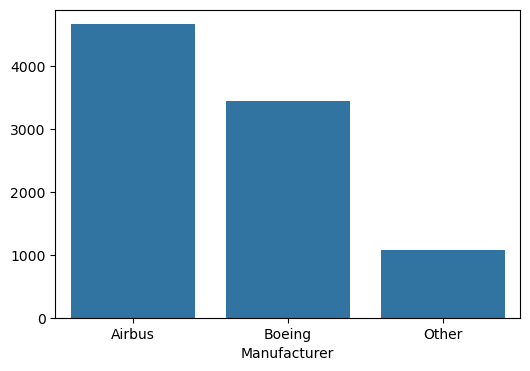

In [15]:
# Total orders for Airbus and Boeing 
total_orders = df.groupby('Manufacturer')['Orders'].sum()

# Chart: Total Orders by Manufacturer
plt.figure(figsize=(6,4))
sns.barplot(x=total_orders.index, y=total_orders.values)
plt.bar(models, orders, color=['#00205b', '#0033a1'])
plt.title('Total Orders: Airbus vs Boeing')
plt.ylabel('Orders')
plt.xlabel('Manufacturer')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\total_orders_manufacturer.png", dpi=300)
plt.show()

In [ ]:
# Filter for Airbus and Boeing
airbus_df = df[df['Aircraft Type'].str.contains('Airbus', case=False, na=False)]
boeing_df = df[df['Aircraft Type'].str.contains('Boeing', case=False, na=False)]

# Group by model and sum orders
order_model_airbus = airbus_df.groupby('Aircraft Type')['Orders'].sum()
order_model_boeing = boeing_df.groupby('Aircraft Type')['Orders'].sum()

# Most and least ordered Airbus models
airbus_successful_model = order_model_airbus.idxmax(), order_model_airbus.max()
airbus_least_successful_model = order_model_airbus.idxmin(), order_model_airbus.min()

# Most and least ordered Boeing models
boeing_successful_model = order_model_boeing.idxmax(), order_model_boeing.max()
boeing_least_successful_model = order_model_boeing.idxmin(), order_model_boeing.min()

# Output
boeing_successful_model, boeing_least_successful_model, airbus_successful_model, airbus_least_successful_model

In [ ]:
# Basic data
models = [
    airbus_successful_model[0],
    airbus_least_successful_model[0],
    boeing_successful_model[0],
    boeing_least_successful_model[0]
]

orders = [
    airbus_successful_model[1],
    airbus_least_successful_model[1],
    boeing_successful_model[1],
    boeing_least_successful_model[1]
]

# bar plot
plt.bar(models, orders, color=['#00205b', '#0033a1'])
plt.title('Most & Least Ordered Aircraft Models')
plt.ylabel('Orders')
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\most_&_least_models.png", dpi=300)
plt.show()

In [ ]:
# Group all aircraft models and find most total orders
most_ordered_model = df.groupby('Aircraft Type')['Orders'].sum().idxmax()
most_orders = df.groupby('Aircraft Type')['Orders'].sum().max()

most_ordered_model, most_orders

In [ ]:
# Group all aircraft models and find most total orders
least_ordered_model = df.groupby('Aircraft Type')['Orders'].sum().idxmin()
least_orders = df.groupby('Aircraft Type')['Orders'].sum().min()

least_ordered_model, least_orders

In [ ]:
# most ordered model and its order count
model_orders = df.groupby('Aircraft Type')['Orders'].sum()
most_ordered_model = model_orders.idxmax()
most_orders = model_orders.max()

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(most_ordered_model, most_orders, color=['#00205b', '#0033a1'])
plt.title('Most Ordered Aircraft Model')
plt.ylabel('Number of Orders')
plt.xlabel('Aircraft Model')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\most_ordered_aircraft_model.png", dpi=300)
plt.show()

In [ ]:
# compare future orders of airbus and boeing
future_orders = {
    'Airbus': airbus_df['Future'].sum(min_count=1),
    'Boeing': boeing_df['Future'].sum(min_count=1)
}

future_orders

In [ ]:
# Data: Future aircraft orders
manufacturers = list(future_orders.keys())
orders = list(future_orders.values())

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(manufacturers, orders, color=['#00205b', '#0033a1'])
plt.title("Future Aircraft Orders: Airbus vs Boeing", fontsize=14)
plt.xlabel("Manufacturer", fontsize=12)
plt.ylabel("Number of Future Orders", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\future_total_orders_manufacturer.png", dpi=300)
plt.show()

In [ ]:
# airlines usages by airbus & boeing
# Group by airline 
top_airbus_airline = airbus_df.groupby('Airline')['Current'].sum().idxmax()
top_boeing_airline = boeing_df.groupby('Airline')['Current'].sum().idxmax()

# get counts of aircraft by airline
airbus_count = airbus_df.groupby('Airline')["Current"].sum().max()
boeing_count = boeing_df.groupby('Airline')["Current"].sum().max()

airbus_count, boeing_count

In [ ]:
# airlines usages by airbus & boeing
# Group by airline 
top_airbus_airline = airbus_df.groupby('Airline')['Current'].sum().idxmax()
top_boeing_airline = boeing_df.groupby('Airline')['Current'].sum().idxmax()

# get counts of aircraft by airline
airbus_count_min = airbus_df.groupby('Airline')["Current"].sum().min()
boeing_count_min = boeing_df.groupby('Airline')["Current"].sum().min()

airbus_count, boeing_count

In [ ]:
# Data: Airline names and their fleet counts
manufacturers = ['Airbus', 'Boeing']
fleet_counts = [airbus_count, boeing_count]
top_airlines = [top_airbus_airline, top_boeing_airline]

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(manufacturers, fleet_counts, color=['#00205b', '#0033a1'])

# Add airline names and values on top of bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f"{top_airlines[i]} ({fleet_counts[i]})", ha='center', fontsize=10, fontweight='bold')

plt.title("Airlines with the Most Airbus and Boeing Aircraft")
plt.ylabel("Number of Aircraft")
plt.ylim(0, max(fleet_counts) + 50)
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\airlines_with_most_aircraft.png", dpi=300)
plt.show()

In [ ]:
def get_manufacturer(aircraft_type):
    if 'Airbus' in str(aircraft_type):
        return 'Airbus'
    elif 'Boeing' in str(aircraft_type):
        return 'Boeing'
    else:
        return 'Other'

# create separte column for manufacturer        
df['Manufacturer'] = df['Aircraft Type'].apply(get_manufacturer)

manufacturer_summary = df.groupby('Manufacturer')[['Future', 'Orders']].sum().reset_index()
manufacturer_summary

In [ ]:
# Set style
sns.set(style="ticks")

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=manufacturer_summary.melt(id_vars='Manufacturer', 
                                                      value_vars=['Future', 'Orders']),
                      x='Manufacturer', y='value', hue='variable',
                      palette={'Future': '#00205b', 'Orders': '#0033a1'})

# Labels and titles
plt.title('Future & Total Orders by Manufacturer')
plt.ylabel('Number of Aircraft')
plt.xlabel('Manufacturer')
plt.legend(title='Order Type')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\future_and_total_orders_manufacturer.png", dpi=300)
plt.show()

In [ ]:
# filter for only airbus vs boieng comparison 
df_filtered = df[df['Manufacturer'].isin(['Airbus', 'Boeing'])]

In [ ]:
df_filtered.groupby('Manufacturer')['Average Age'].mean().plot(kind='barh', color='#00205b')
plt.title('Average Fleet Age by Manufacturer')
plt.xlabel('Years')
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\avg_fleet_age.png", dpi=300)
plt.show()

In [ ]:
# Top airlines with most orders "desc"

df.groupby('Parent Airline')['Orders'].sum().sort_values(ascending=False).head(10).plot(kind='bar', color='#00205b')
plt.title('Top Airlines by Aircraft Orders')
plt.ylabel('No. of Orders')
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\top_airlines_orders.png", dpi=300)
plt.show()

In [ ]:
# Filtering the Indian Airlines order
indian_airlines = ['Air India', 'IndiGo', 'SpiceJet', 'AirAsia India']
indian_airlines

In [ ]:
# Grouping all airlines (India) Orders
df_india = df[df['Parent Airline'].isin(indian_airlines)]
df_india.groupby('Parent Airline')[['Historic', 'Future']].sum()

In [ ]:
# comparing future orders of indian airlines
df_india_filtered = df_india[df_india['Manufacturer'].isin(['Airbus', 'Boeing'])]

future_orders = df_india_filtered.groupby(['Parent Airline', 'Manufacturer'])['Future'].sum().reset_index().head()
future_orders

In [ ]:
# Visualizing future order by indian airlines
plt.figure(figsize=(10,6))
sns.barplot(data=future_orders, x='Parent Airline', y='Future', hue='Manufacturer', palette= {'#00205b', '#0033a1'})

plt.title('Future Orders by Indian Airlines', fontsize=14)
plt.ylabel('No. of Future Orders')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\future_orders_by_indies_airlines.png", dpi=300)
plt.show()

In [ ]:
# creating a new columns Total Orders
df['Total Orders'] = df['Historic'] + df['Current'] + df['Future']
boeing_df1 = df[df['Manufacturer'] == 'Boeing']
airbus_df1 = df[df['Manufacturer'] == 'Airbus']

In [ ]:
# Total orders: Boeing
boeing_total_orders = boeing_df1.groupby(['Parent Airline', 'Aircraft Type'])['Total Orders'].sum().reset_index().sort_values(by='Total Orders', ascending=False).head()
boeing_total_orders

In [ ]:
# Define Boeing blue color palette
boeing_palette = {
    '#0033a1'
}

plt.figure(figsize=(12, 6))

sns.barplot(
    data=boeing_total_orders,
    y='Parent Airline',
    x='Total Orders',
    hue='Aircraft Type',
    dodge=False,
    palette=boeing_palette  
)

plt.title('Top Boeing Aircraft Orders by Airlines (Total: Historic + Current + Future)', fontsize=14)
plt.xlabel('Total Orders')
plt.ylabel('Airline')
plt.legend(title='Boeing Aircraft Type')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\top_boeing_aircrafts_orders_by_airlines.png", dpi=300)
plt.show()

In [ ]:
# Total Airbus orders
airbus_total_orders = airbus_df1.groupby(['Parent Airline', 'Aircraft Type'])['Total Orders'].sum().reset_index().sort_values(by='Total Orders', ascending=False).head()
airbus_total_orders

In [ ]:
plt.figure(figsize=(12, 6))

# Airbus blue-inspired palette (feel free to tweak or use Airbus branding)
airbus_palette = {
    '#00205B'
}

# Plot horizontal bar chart
sns.barplot(
    data=airbus_total_orders,
    y='Parent Airline',
    x='Total Orders',
    hue='Aircraft Type',
    dodge=False,
    palette=airbus_palette  
)

plt.title('Top Airbus Aircraft Orders (Total: Historic + Current + Future)', fontsize=14)
plt.xlabel('Total Orders')
plt.ylabel('Airline')
plt.legend(title='Airbus Aircraft Type')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\top_airbus_orders.png", dpi=300)
plt.show()

In [ ]:
# total orders: aircraft models
df.groupby('Aircraft Type')['Total Orders'].sum().sort_values(ascending=False).head().plot(kind='bar')

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='Manufacturer', y='Orders')
plt.title('Distribution of Orders by Manufacturer')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='Manufacturer', y='Average Age')
plt.title('Distribution of Fleet Age by Manufacturer')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\distribution_of_orders_by_manufacturer.png", dpi=300)
plt.show()

In [ ]:
sns.pairplot(df[['Orders', 'Current', 'Future', 'Total', 'Average Age', 'Manufacturer']], hue='Manufacturer')
plt.suptitle('Pairplot: Relationships Between Key Metrics', y=1.02)
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\relationship_between_key_metrics.png", dpi=300)
plt.show()

In [ ]:
df_sorted = df.sort_values('Historic')

df_sorted['rolling_orders'] = df_sorted['Orders'].rolling(window=10).mean()

plt.figure(figsize=(10,5))
plt.plot(df_sorted['Historic'], df_sorted['rolling_orders'])
plt.title('10-Model Rolling Average of Orders')
plt.xlabel('Historic')
plt.ylabel('Rolling Orders')
plt.grid(True)
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\avg_orders.png", dpi=300)
plt.show()

In [ ]:
df['Revenue Potential'] = df['Orders'] * df['Unit Cost']

model_revenue = (
    df.groupby('Aircraft Type')['Revenue Potential']
      .sum()
      .rename('Revenue Potential')      # stays 1D
      .sort_values(ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(
    x=model_revenue.head(10).values, 
    y=model_revenue.head(10).index
)
plt.title('Top 10 Aircraft Models by Revenue Potential')
plt.xlabel('Revenue Potential')
plt.ylabel('Aircraft Model')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\top_10_model_revenue.png", dpi=300)
plt.show()

In [ ]:
# Profitability Ratio
df['Revenue per Aircraft'] = df['Revenue Potential'] / (df['Current'] + df['Future'] + 1)

In [ ]:
top_profitability = (
    df.groupby('Aircraft Type')['Revenue per Aircraft'].mean()
      .sort_values(ascending=False)
      .head(10)
)

top_profitability

In [ ]:
# Airlies Revenues 
airline_revenue = (
    df.groupby('Airline')['Revenue Potential']
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

airline_revenue

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(
    y=airline_revenue.index, 
    x=airline_revenue.values
)
plt.title('Top 10 Airlines by Revenue Contribution')
plt.xlabel('Revenue Potential')
plt.ylabel('Airline')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\top_airlines_revenue_ccontribution.png", dpi=300)
plt.show()